## LeNet

- 之前，将softmax回归模型和多层感知机模型应用于Fashion-MNIST数据集中的服装图片
    - 为了能够应用softmax回归和多层感知机，首先将每个大小为$28\times28$的图像**展平为一个784维的固定长度的一维向量**，然后用全连接层对其进行处理
- 通过卷积层的处理方式，可以在图像中保留空间结构
    - 用卷积层代替全连接层还可以使得：模型更简洁、所需参数更少

### MNIST
- 50,000个训练数据
- 10,000个训练数据
- 图像大小$28\times28$
- 10类

- LeNet(LeNet-5)由两部分组成：
    - 卷积编码器：由两个卷积层组成
    - 全连接层密集块：由三个全连接层组成
    - 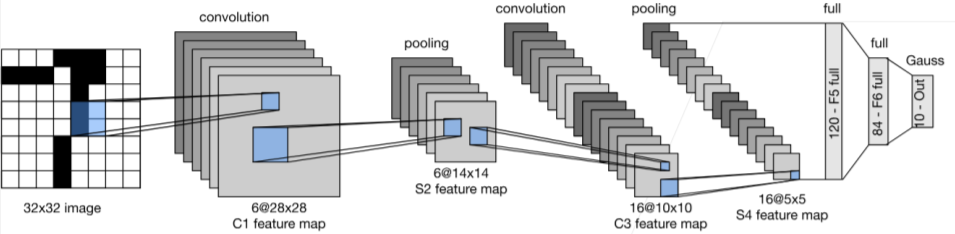

### 总结
- LeNet是早期成功的神经网络
- 先试用卷积层来学习图片空间信息
- 然后使用全连接层来转换到类别空间

### LeNet
- 对原始模型做了一点小改动，去掉了最后一层的高斯激活
- `16 * 5 * 5`就是得到的大小（计算可得）

In [ ]:
import torch

from d2l import torch as d2l
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

net = nn.Sequential(nn.Linear(5, 10), nn.ReLU(), nn.Linear(10, 3))

num_samples = 10
num_features = 5
num_classes = 3

# 训练数据集
X_train = torch.randn(num_samples, num_features)
y_train = torch.randint(0, num_classes, (num_samples,))
train_dataset = TensorDataset(X_train, y_train)
train_iter = DataLoader(train_dataset, batch_size=2, shuffle=True)

# 测试数据集
X_test = torch.randn(num_samples, num_features)
y_test = torch.randint(0, num_classes, (num_samples,))
test_dataset = TensorDataset(X_test, y_test)
test_iter = DataLoader(train_dataset, batch_size=2, shuffle=True)


def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

num_epochs = 3
lr = 0.1
device = torch.device('cpu')

train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

training on cpu


In [1]:
import torch
import torchvision

from torchvision import transforms
from torch.utils import data
from torch import nn
from d2l import torch as d2l

class Reshape(nn.Module):
    def forward(self, X):
        return X.reshape((-1, 1, 28, 28))

net = nn.Sequential(
    Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

**检查模型**

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


#### **思想**：高宽不断减小，通道数不断增加，最后通过MLP得到输出

### 模型训练
**LeNet在Fashion-MNIST数据集上的表现**

In [2]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNSIT数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='..\data', train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='.\data', train=False, transform=trans, download=True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=1))

batch_size = 10
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

C:\Users\lenovo\.conda\envs\fxr_env2\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

**为了使用GPU，对`evaluate_accuracy`函数进行轻微的修改**
- 要将数据放入`device`中才可以

In [4]:
def evalutate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    # 先指定device
    if isinstance(net, nn.Module):
        net.eval()
        if not devcie:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            
            metric.add(d2l.accuracy(X, y), y.numel())
    return metirc[0] / metric[1]

**同样为了使用GPU，也需要对`train`函数进行一些改动**

In [6]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    # 模型参数初始化
    def init_weight(m):
        if type(m) == nn.Linear or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    print('trianing on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    animator = d2l.Animator(
        xlabel='epoch', xlim=[1, num_epochs], 
        legend=['trian loss', 'train acc', 'test acc']
    )
    timer, num_batches = d2l.Timer(), len(train_iter)

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')     

In [ ]:
torch.backends.cudnn.enabled = False

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

training on cuda:0


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [1]:
!nvidia-smi

Wed Oct 30 20:48:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.49       Driver Version: 457.49       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX150      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0    N/A /  N/A |     64MiB /  2048MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 小结
- 卷积神经网络（CNN）是一类使用卷积层的网络
- 在卷积神经网络中，组合使用卷积层、非线性激活函数和池化层
- 为了构造高性能的卷积神经网络，**通常对卷积层进行排列，逐渐降低其表示的空间分辨率。同时增加通道数**
- 在传统的卷积神经网络中，卷积块编码得到的表征**在输出前需要一个或多个全连接层进行处理**

### 练习

In [1]:
import time
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

def use_svg_display():
    """Use the svg format to display plots in Jupyter."""
    display.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale='linear', yscale='linear', legend=None):
    """设置matplotlib图表的坐标轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:  
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.start_time = time.time()

    def stop(self):
        """Stop the timer and record the elapsed time."""
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n  # 创建一个长度为n的列表data

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:  
        y_hat = y_hat.argmax(axis=1) # 返回最大值所在索引
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())